In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta del archivo Excel
filePath = '../sdei-annual-pm2-5/sdei-annual-pm2-5-concentrations-countries-urban-areas-v1-1998-2016-xlsx.xlsx'

# Verificar si el archivo existe
if not os.path.exists(filePath):
    print(f"No se encontró el archivo: {filePath}")
    exit()

# Cargar el archivo Excel
excelData = pd.ExcelFile(filePath)

# Mostrar los nombres de las hojas disponibles
sheetNames = excelData.sheet_names
print("Hojas disponibles:", sheetNames)

# Cargar las hojas relevantes en DataFrames
countryPm25ExposureDf = excelData.parse('Country PM2.5 Exposure')
countryPm25ExceedanceDf = excelData.parse('Country PM2.5 Exceedance')
urbanPm25ExposureDf = excelData.parse('Urban PM2.5 Exposure')

/home/juan27/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Hojas disponibles: ['Title Page', 'Guide', 'Data Dictionary', 'Country PM2.5 Exposure', 'Country PM2.5 Exceedance', 'Urban PM2.5 Exposure']


/home/juan27/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [2]:
countryPm25ExposureDf.sample(5)
filteredColsExpo = ['COUNTRY'] + [col for col in countryPm25ExposureDf.columns if col.startswith('AVPMC_')] 
filteredCountryExpoDf = countryPm25ExposureDf[filteredColsExpo]
filteredCountryExpoDf.sample(5)

,COUNTRY,AVPMC_2008,AVPMC_2009,AVPMC_2010,AVPMC_2011,AVPMC_2012,AVPMC_2013,AVPMC_2014,AVPMC_2015
121,Malawi,11.174570,11.272998,11.205500,11.809237,13.424013,11.070653,11.331174,12.415418
85,Guyana,1.309925,1.216735,1.223223,1.152165,1.787883,1.583132,1.209286,1.475726
16,Bangladesh,47.492200,54.683254,47.671069,47.529125,54.263629,48.239111,58.190187,60.274334
58,Egypt,7.909315,7.347495,7.629447,6.214376,6.961596,7.792175,7.643619,10.879699
217,Turkmenistan,8.953354,8.791201,8.479019,9.600546,8.551994,9.426737,9.051179,10.577546


In [10]:
countriesExpo = filteredCountryExpoDf['COUNTRY'].dropna().drop_duplicates().tolist()
countriesExpo[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia']

In [3]:
countryPm25ExceedanceDf.sample(5)
filteredColsExce = ['COUNTRY'] + [col for col in countryPm25ExceedanceDf.columns if col.startswith('PMEXDC_')]
filteredCountryExceDf = countryPm25ExceedanceDf[filteredColsExce]
filteredCountryExceDf.sample(5)


,COUNTRY,PMEXDC_2008,PMEXDC_2009,PMEXDC_2010,PMEXDC_2011,PMEXDC_2012,PMEXDC_2013,PMEXDC_2014,PMEXDC_2015
179,Samoa,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
10,Aruba,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
44,Cook Islands,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000
76,Gibraltar,0.0,0.0,1.27126,4.096819,0.0,4.096819,4.096819,7.904627
86,Haiti,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.000000


In [12]:
countriesExce = filteredCountryExceDf['COUNTRY'].dropna().drop_duplicates().tolist()
countriesExce[:10]

['Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia']

In [4]:
urbanPm25ExposureDf.sample(5)
filteredColsUrban = ['CONTINENT', 'COUNTRYENG', 'STNDRDNAME'] + [col for col in urbanPm25ExposureDf.columns if col.startswith('AVPMU_')]
filteredUrbanExpoDf = urbanPm25ExposureDf[filteredColsUrban]
filteredUrbanExpoDf.sample(5)

,CONTINENT,COUNTRYENG,STNDRDNAME,AVPMU_1998,AVPMU_1999,AVPMU_2000,AVPMU_2001,AVPMU_2002,AVPMU_2003,AVPMU_2004,...,AVPMU_2007,AVPMU_2008,AVPMU_2009,AVPMU_2010,AVPMU_2011,AVPMU_2012,AVPMU_2013,AVPMU_2014,AVPMU_2015,AVPMU_2016
4804,Europe,Romania,ROVINARI,19.711688,16.454545,15.641558,18.290909,19.784416,18.398701,16.664935,...,14.098701,14.215584,16.942857,19.453247,17.014286,16.638961,15.705195,16.112987,17.646753,16.712987
26633,Africa,Mali,KANGARE,7.120000,5.320000,4.820000,6.400000,6.700000,6.480000,7.500000,...,4.800000,4.520000,4.500000,4.960000,6.300000,7.080000,4.820000,4.240000,6.280000,4.620000
7215,Americas-North America,United States of America,CARLIN,3.600394,4.350787,5.240551,4.520866,4.896457,4.955118,4.177165,...,5.468898,4.892913,4.307480,3.654724,3.895669,4.535039,3.899606,3.503150,5.481890,4.722441
16695,Americas-North America,Mexico,ZINAPECUARODEFIGUEROA,41.557778,15.520000,17.557778,17.251111,19.093333,17.888889,17.771111,...,16.322222,15.391111,16.297778,14.282222,18.462222,17.964444,18.377778,14.368889,13.728889,14.808889
11278,Americas-North America,United States of America,LAKEHAVASU,8.194265,7.175269,7.183513,7.271326,6.861649,7.371326,6.513262,...,6.660932,6.423656,5.773477,5.342652,5.824014,6.589964,6.191039,5.207168,9.128315,10.396057


In [16]:
[continetUrban , countriesUrban, cityUrban]  = [filteredUrbanExpoDf['CONTINENT'].dropna().drop_duplicates().tolist() , filteredUrbanExpoDf['COUNTRYENG'].dropna().drop_duplicates().tolist(), filteredUrbanExpoDf['STNDRDNAME'].dropna().drop_duplicates().tolist()]
continetUrban[:10], countriesUrban[:5], cityUrban[:5]

(['Americas-North America',
  'Europe',
  'Oceania',
  'Americas-South America',
  'Asia',
  'Africa'],
 ['Greenland',
  'United States of America',
  'Norway',
  'Russia',
  'Wallis and Futuna'],
 ['UPERNAVIK', 'BARROW', 'HONNINGSVAG', 'HAVOYSUND', 'KJOLLEFJORD'])

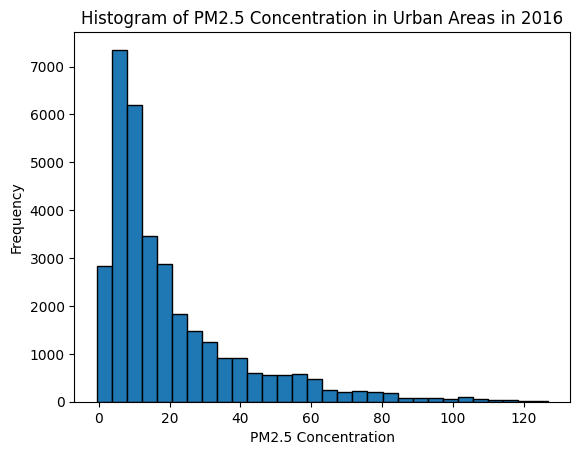

In [6]:
plt.hist(filteredUrbanExpoDf['AVPMU_2016'], bins=30, edgecolor='black')
plt.xlabel('PM2.5 Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of PM2.5 Concentration in Urban Areas in 2016')
plt.show()

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ruta del archivo Excel
filePath = '../sdei-annual-pm2-5/sdei-annual-pm2-5-concentrations-countries-urban-areas-v1-1998-2016-xlsx.xlsx'

# Verificar si el archivo existe
if not os.path.exists(filePath):
    print(f"No se encontró el archivo: {filePath}")
    exit()

# Cargar el archivo Excel
excelData = pd.ExcelFile(filePath)

# Mostrar los nombres de las hojas disponibles
sheetNames = excelData.sheet_names
print("Hojas disponibles:", sheetNames)

# Información de las hojas a cargar y los filtros a aplicar
sheet_info = {
    'Country PM2.5 Exposure': {
        'filter_prefix': 'AVPMC_',
        'filter_cols': ['COUNTRY']
    },
    'Country PM2.5 Exceedance': {
        'filter_prefix': 'PMEXDC_',
        'filter_cols': ['COUNTRY']
    },
    'Urban PM2.5 Exposure': {
        'filter_prefix': 'AVPMU_',
        'filter_cols': ['CONTINENT', 'COUNTRYENG', 'STNDRDNAME']
    }
}

def load_and_filter_sheet(excel_data, sheet_name, filter_prefix, filter_cols):
    # Cargar la hoja
    df = excel_data.parse(sheet_name)
    # Mostrar una muestra de los datos
    print(f"\nMuestra de '{sheet_name}':")
    print(df.sample(5))
    # Filtrar las columnas
    filtered_columns = filter_cols + [col for col in df.columns if col.startswith(filter_prefix)]
    filtered_df = df[filtered_columns]
    # Mostrar una muestra de los datos filtrados
    print(f"\nMuestra filtrada de '{sheet_name}':")
    print(filtered_df.sample(5))
    return filtered_df

# Diccionario para almacenar los DataFrames filtrados
filtered_dataframes = {}

# Cargar y filtrar cada hoja
for sheet_name, info in sheet_info.items():
    filtered_df = load_and_filter_sheet(
        excelData,
        sheet_name,
        info['filter_prefix'],
        info['filter_cols']
    )
    filtered_dataframes[sheet_name] = filtered_df


Hojas disponibles: ['Title Page', 'Guide', 'Data Dictionary', 'Country PM2.5 Exposure', 'Country PM2.5 Exceedance', 'Urban PM2.5 Exposure']

Muestra de 'Country PM2.5 Exposure':
     CODE  ISO           COUNTRY  AVPMC_2008  AVPMC_2009  AVPMC_2010  \
72    270  GMB            Gambia    3.817990    3.592703    3.752095   
217   795  TKM      Turkmenistan    8.953354    8.791201    8.479019   
65    238  FLK  Falkland Islands    0.285800    0.268219    0.290652   
115   438  LIE     Liechtenstein    9.758777    9.162697    8.539775   
135   496  MNG          Mongolia    5.774580    5.230855    5.215764   

     AVPMC_2011  AVPMC_2012  AVPMC_2013  AVPMC_2014  AVPMC_2015  
72     3.730561    4.094590    3.606413    3.472675    4.932146  
217    9.600546    8.551994    9.426737    9.051179   10.577546  
65     0.310241    0.276423    0.269202    0.269917    0.281991  
115    9.245241   10.618089    9.102619   15.828998    8.207428  
135    5.593734    5.030730    5.421578    4.716330    6.45

/home/juan27/.local/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")



Muestra de 'Urban PM2.5 Exposure':
       URBID STNDRDNAME       NAME  ISOURBID        SQKM     COUNTRYENG ISO3  \
30976  92128    SHIGANG    Shigang  CHN92128   33.110001          China  CHN   
20812  63733     ARARAS     Araras  BRA63733  150.871994         Brazil  BRA   
29810  90959  ZHOUCHENG  Zhoucheng  CHN90959   33.175400          China  CHN   
30474  91624      FUREN      Furen  CHN91624   17.304300          China  CHN   
23149  90006     BAFATA     Bafata  GNB90006   33.077702  Guinea-Bissau  GNB   

       UNSDCODE               CONTINENT  AVPMU_1998  ...  AVPMU_2007  \
30976       156                    Asia   25.103125  ...   42.353125   
20812        76  Americas-South America   16.470000  ...   13.750769   
29810       156                    Asia   36.088235  ...   83.058823   
30474       156                    Asia   26.631250  ...   44.475000   
23149       624                  Africa    7.926923  ...    4.365385   

       AVPMU_2008  AVPMU_2009  AVPMU_2010  AVPMU_2